# Prototype code for creating PSTH using fiber photometry data
* setup 12/11/2024 GT

In [12]:
from os.path import join

import pandas as pd

from src import TDT_experiment as tdt
import metadata


In [28]:
def df_type_annotation(df: pd.DataFrame) -> pd.DataFrame:
    df["Frame"] = df["Frame"].astype(int)
    df["Shock"] = df["Shock"].astype(int)
    df["dFF"] = df["dFF"].astype(float)
    df["Freezing"] = df["Freezing"].astype(int)
    return df


def parse_mouse_id(series: pd.Series) -> pd.Series:
    series = series.str.split("_", expand=True)
    return series[0] + "_" + series[1]


def get_day1_data(folder_name):
    """
    Extracts and processes day 1 data from a specified folder.
    Parameters:
    folder_name (str): The name of the folder containing the experiment data.
    Returns:
    pandas.DataFrame: A DataFrame containing the processed data with columns:
                      - 'mouse_id': The ID of the mouse.
                      - 'dFF': The delta F/F values.
                      - 'Shock': The shock values.
    """
    exp = tdt.TDTExperiment(join(metadata.ROOT_DATA_DIR, folder_name))
    fiber_df = pd.read_csv(join(exp.analysis_path, "fiber_freezing_output.csv"))
    df_annot = df_type_annotation(fiber_df)
    df_annot["mouse_id"] = parse_mouse_id(df_annot["Mouse ID"])
    day1_data = df_annot[["mouse_id", "dFF", "Shock"]]

    return day1_data


def process_all_day1_data(day1_df):
    all_data = []

    # Iterate through the "Folder Name" column
    for folder_name in day1_df["Folder Name"]:
        result_df = get_day1_data(
            folder_name
        )  # This returns the filtered DataFrame (mouse_id, dFF, Shock)
        all_data.append(result_df)

    # Concatenate all individual DataFrames into one long DataFrame
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

In [7]:
df = pd.read_excel(metadata.GOOD_METADATA)
day1_df = df[df["day"] == "day_1"]
day1_df.reset_index(drop=True, inplace=True)

In [32]:
all_day1_data = process_all_day1_data(day1_df)

In [33]:
all_day1_data

,mouse_id,dFF,Shock
0,nia_08,0.016225,0
1,nia_08,0.360011,0
2,nia_08,0.314153,0
3,nia_08,-0.089399,0
4,nia_08,-0.486703,0
...,...,...,...
42721,nia_29,0.059994,0
42722,nia_29,-0.136814,0
42723,nia_29,-0.153798,0
42724,nia_29,0.073016,0


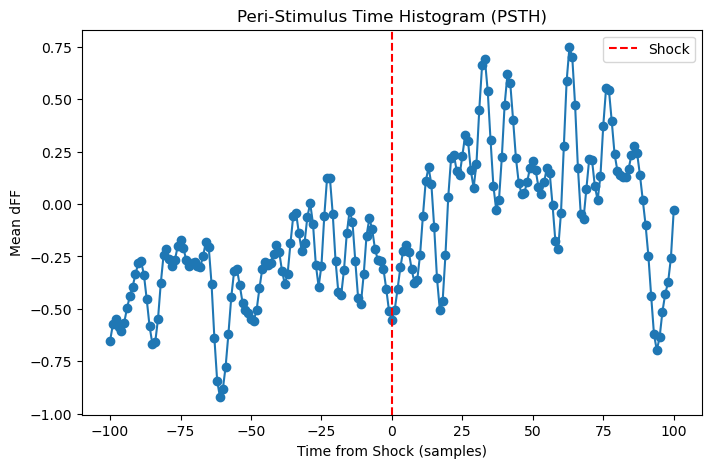

In [37]:
import pandas as pd

# Assume all_day1_data has columns:
# "Folder Name", "mouse_id", "dFF", "Shock"
# and possibly others.

# The column identifying each trial. Adjust as needed:
trial_column = "mouse_id"

# Time window around shock (in number of rows)
pre_shock = 100  # 10 rows before shock
post_shock = 100  # 10 rows after shock

# We'll store aligned data from each trial
aligned_data = []

# Group by each trial
for trial_id, trial_df in all_day1_data.groupby(trial_column):
    # Find the index of the shock event
    shock_indices = trial_df[trial_df["Shock"] == 100].index
    if len(shock_indices) != 1:
        # If there's not exactly one shock event, handle accordingly
        continue

    shock_idx = shock_indices[0]

    # Determine the slicing window around shock
    start_idx = shock_idx - pre_shock
    end_idx = shock_idx + post_shock

    # Check boundaries
    if start_idx < trial_df.index.min() or end_idx > trial_df.index.max():
        # If the window extends beyond the data, handle accordingly (skip or truncate)
        continue

    # Slice the trial data around the shock event
    window_df = trial_df.loc[start_idx:end_idx].copy()

    # Create a relative time index: shock at time zero
    # If each row represents one time unit, we can do:
    window_df["time_from_shock"] = window_df.index - shock_idx

    # Keep only the relevant columns
    # We need "time_from_shock" and "dFF" for averaging later
    aligned_data.append(window_df[["time_from_shock", "dFF"]])

# Concatenate all aligned trials
if not aligned_data:
    raise ValueError("No aligned data found; check data and shock events.")

aligned_df = pd.concat(aligned_data, ignore_index=True)

# Compute the PSTH by averaging dFF at each time_from_shock across trials
psth = aligned_df.groupby("time_from_shock")["dFF"].mean().reset_index()

# `psth` now contains the mean dFF at each time_from_shock.
# You can plot this using matplotlib or seaborn:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(psth["time_from_shock"], psth["dFF"], marker="o")
plt.axvline(0, color="r", linestyle="--", label="Shock")
plt.xlabel("Time from Shock (samples)")
plt.ylabel("Mean dFF")
plt.title("Peri-Stimulus Time Histogram (PSTH)")
plt.legend()
plt.show()


==============================================

In [ ]:
exp = tdt.TDTExperiment(join(metadata.ROOT_DATA_DIR,
                             day1_df.loc[0]["Folder Name"]))

In [22]:
fiber_df = pd.read_csv(join(exp.analysis_path, "fiber_freezing_output.csv"))
fiber_df.tail(2)

,File,Mouse ID,Frame,Time_from_shock,Shock,dFF,Freezing
6101,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,6101,29.984354,0.0,0.499714,0.0
6102,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,6102,29.994184,0.0,-0.605451,0.0


In [ ]:
df_annot = df_type_annotation(fiber_df)
df_annot["mouse_id"] = parse_mouse_id(df_annot["Mouse ID"])

,File,Mouse ID,Frame,Time_from_shock,Shock,dFF,Freezing,mouse_id
0,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,0,-29.990915,0,0.016225,0,nia_08
1,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,1,-29.981085,0,0.360011,0,nia_08
2,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,2,-29.971254,0,0.314153,0,nia_08
3,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,3,-29.961424,0,-0.089399,0,nia_08
4,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,4,-29.951594,0,-0.486703,0,nia_08
...,...,...,...,...,...,...,...,...
6098,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,6098,29.954863,0,-0.941437,0,nia_08
6099,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,6099,29.964693,0,0.014908,0,nia_08
6100,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,6100,29.974524,0,0.725218,0,nia_08
6101,pattern-240604-113630_nia_8-240611-132124_Cam1...,nia_08_5HT_cxtA_day_1,6101,29.984354,0,0.499714,0,nia_08
